In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

print(tf.test.is_built_with_cuda())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


True
Num GPUs Available:  1


In [2]:
RECORDS_PATH = "../data/records"
TRAIN_FILENAMES = tf.io.gfile.glob(RECORDS_PATH + "/train/train_*.tfrecord")
VAL_FILENAMES = tf.io.gfile.glob(RECORDS_PATH + "/val/val_*.tfrecord")
VISUAL_FILENAMES = ["../data/records/visual.tfrecord"]

print(f"Number of training files: {len(TRAIN_FILENAMES)}")
print(f"Number of validation files: {len(VAL_FILENAMES)}")

Number of training files: 203
Number of validation files: 26


In [250]:
EMBEDDING_DIM = 16
JUDGMENT_DIM = 4
BEATMAP_CONTEXT_DIM = 4

FEATURE_DESCRIPTION = {
    "embeddings": tf.io.VarLenFeature(dtype = tf.float32),
    "judgments": tf.io.VarLenFeature(dtype = tf.float32),
    "beatmap_context": tf.io.FixedLenFeature([8], dtype = tf.float32),
    "replay_length": tf.io.FixedLenFeature([], dtype = tf.int64),
}

### Build TF Dataset Loader

In [255]:
NOTES_PER_EXAMPLE = 8
NOTES_PER_REPLAY = 256

def reformat_example(example):

    feature_tensor_slices = []
    label_tensor_slices = []

    replay_len = example["replay_length"]
    embeddings = tf.reshape( example["embeddings"].values, [replay_len, EMBEDDING_DIM])
    judgments  = tf.reshape( example["judgments"].values, [replay_len, JUDGMENT_DIM])
    beatmap_context = tf.gather( example["beatmap_context"], indices = [0, 1, 2, 5] ) # discard all mods (but hd) and stack leniency
    beatmap_context = tf.reshape( beatmap_context , [1, BEATMAP_CONTEXT_DIM ] )
     
    for note_idx in range(NOTES_PER_REPLAY):
        feature_tensor_slices.append(
            tf.concat([
                beatmap_context, 
                tf.reshape(embeddings[replay_len - note_idx - NOTES_PER_EXAMPLE : replay_len - note_idx , :], [1, NOTES_PER_EXAMPLE * EMBEDDING_DIM])
            ], axis = 1)
        )
        label_tensor_slices.append(
            tf.reshape(judgments[replay_len - note_idx - 1, :], [1, JUDGMENT_DIM])
        )
    
    feature_tensor = tf.concat(feature_tensor_slices, axis = 0)
    label_tensor = tf.concat(label_tensor_slices, axis = 0)
    
    feature_dataset = tf.data.Dataset.from_tensor_slices(feature_tensor)
    label_dataset = tf.data.Dataset.from_tensor_slices(label_tensor)
    
    return tf.data.Dataset.zip((feature_dataset, label_dataset))


def filter_example_len(example):
    return tf.greater_equal(example["replay_length"], NOTES_PER_EXAMPLE + NOTES_PER_REPLAY)

def filter_example_ez(example):
    return tf.less(example["beatmap_context"][4], 0.9 ) 

def filter_example_dt(example):
    return tf.less(example["beatmap_context"][6], 0.9 ) 
        
def filter_example_hr(example):
    return tf.less(example["beatmap_context"][7], 0.9 ) 
            

def parse_example(raw_data):
    example_obj = tf.io.parse_single_example(raw_data, FEATURE_DESCRIPTION)
    return example_obj


In [256]:
BATCH_SIZE = 256
SHUFFLE_BUFFER_SIZE = 4096

def load_dataset(filenames):

    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable order, increase speed

    dataset = tf.data.TFRecordDataset(
        filenames,
        compression_type = "ZLIB"
    ) 

    dataset = dataset.with_options(
        ignore_order
    ) 

    dataset = dataset.map(
        parse_example, num_parallel_calls = tf.data.AUTOTUNE
    )

    return dataset


def get_dataset(filenames):

    dataset = load_dataset(filenames)
    dataset = dataset.filter(filter_example_len)
    dataset = dataset.filter(filter_example_ez)
    dataset = dataset.filter(filter_example_dt)
    dataset = dataset.filter(filter_example_hr)
    dataset = dataset.flat_map(reformat_example)
    dataset = dataset.shuffle(SHUFFLE_BUFFER_SIZE, reshuffle_each_iteration = True)
    dataset = dataset.prefetch(buffer_size = tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)

    return dataset

In [262]:
train_dataset = get_dataset(TRAIN_FILENAMES)
val_dataset = get_dataset(VAL_FILENAMES)

In [135]:
#127000 total batches (replays)

### Do Grid Search

In [385]:

def build_naive_model(num_hidden_layers, hidden_layer_size, pct_dropout):
    
    inputs = tf.keras.layers.Input(shape = [NOTES_PER_EXAMPLE * EMBEDDING_DIM + BEATMAP_CONTEXT_DIM,])
    
    x = tf.keras.layers.Dense(hidden_layer_size, activation = "relu", name = "hidden_0")(inputs)
    x = tf.keras.layers.Dropout(pct_dropout, name = "dropout_0")(x)

    for i in range(1, num_hidden_layers):
        x = tf.keras.layers.Dense(hidden_layer_size, activation = "relu", name = f"hidden_{i}")(x)
        x = tf.keras.layers.Dropout(pct_dropout, name = f"dropout_{i}")(x)

    outputs = tf.keras.layers.Dense(JUDGMENT_DIM, activation = "softmax", name = "output_layer")(x)

    model = tf.keras.Model(inputs = inputs, outputs = outputs, name = f"{num_hidden_layers}_{hidden_layer_size}_{pct_dropout}")

    return model


def get_lr_schedule(init_learning_rate, decay_step_count):
    return tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate = init_learning_rate, decay_steps = decay_step_count, decay_rate = 0.96, staircase = True
    )
    

In [ ]:
HIDDEN_LAYER_COUNTS = (3, 4, 5)
HIDDEN_LAYER_SIZES = (128, 256, 512)
DROPOUT_PERCENTS = (0.2, 0.1, 0.05)

INIT_LEARNING_RATES = (0.01, 0.001, 0.0001)
DECAY_STEPS_COUNTS = (1000, 100, 10)

NUM_EPOCHS = 8
STEPS_PER_EPOCH = 4096

histories = []

for hidden_layer_count in HIDDEN_LAYER_COUNTS:
    for hidden_layer_size in HIDDEN_LAYER_SIZES:
        for dropout_percent in DROPOUT_PERCENTS:
            for init_learning_rate in INIT_LEARNING_RATES:
                for decay_step_count in DECAY_STEPS_COUNTS:
                    
                    print(f"\n\nTraining model {(hidden_layer_count,hidden_layer_size,dropout_percent)} with scheduler {(init_learning_rate, decay_step_count)}...\n")
                    
                    model = build_naive_model(
                        num_hidden_layers = hidden_layer_count,
                        hidden_layer_size = hidden_layer_size,
                        pct_dropout = dropout_percent,   
                    )
                    
                    lr_schedule = get_lr_schedule(
                        init_learning_rate = init_learning_rate,
                        decay_step_count = decay_step_count
                    )
                    
                    model.compile(
                        optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule),
                        loss = "categorical_crossentropy",
                        metrics = [
                            tf.keras.metrics.CategoricalAccuracy(name = "categorical_acc"), 
                            tf.keras.metrics.CosineSimilarity(name = "cosine_sim"),
                        ]
                    )
                    
                    history = model.fit(
                        
                        train_dataset,
                        epochs = NUM_EPOCHS,
                        steps_per_epoch = STEPS_PER_EPOCH,
                        
                        validation_data = val_dataset,
                        validation_steps = 1,
                        validation_batch_size = 1024,
                
                        verbose = 1
                        
                    )
                    
                    histories.append([
                        (hidden_layer_count, hidden_layer_size, dropout_percent, init_learning_rate, decay_step_count), 
                        history
                    ])

In [412]:
grid_search_df = pd.read_csv("../results/naive_grid_search.csv")
grid_search_df["val_agg"] = grid_search_df.apply(lambda row: (row["val_loss_4"] + row["val_loss_5"] + row["val_loss_6"] + row["val_loss_7"]) / 4, axis = 1)
grid_search_df.sort_values(by = "val_agg")[:10]

,hidden_layer_count,hidden_layer_size,dropout_percent,init_learning_rate,decay_step_count,loss_0,loss_1,loss_2,loss_3,loss_4,...,loss_7,val_loss_0,val_loss_1,val_loss_2,val_loss_3,val_loss_4,val_loss_5,val_loss_6,val_loss_7,val_agg
118,4,256,0.10,0.0100,100,0.537977,0.351619,0.352871,0.355871,0.345749,...,0.348204,0.254482,0.224323,0.280254,0.234687,0.204503,0.241970,0.209655,0.213515,0.217411
21,3,128,0.05,0.0010,1000,0.507161,0.350985,0.351927,0.354578,0.343306,...,0.344558,0.310231,0.202187,0.242740,0.242410,0.222177,0.157994,0.276969,0.221207,0.219587
22,3,128,0.05,0.0010,100,0.459307,0.352985,0.355837,0.359254,0.349244,...,0.351520,0.274646,0.206751,0.350222,0.279899,0.290409,0.194614,0.199750,0.215636,0.225102
171,5,128,0.10,0.0100,1000,0.401018,0.369768,0.372992,0.374736,0.374118,...,0.364563,0.348678,0.335590,0.287278,0.242717,0.245640,0.219773,0.204167,0.237492,0.226768
120,4,256,0.10,0.0010,1000,0.464510,0.350737,0.352377,0.354798,0.343594,...,0.344945,0.324867,0.249561,0.255917,0.246260,0.219154,0.281361,0.177936,0.237792,0.229061
39,3,256,0.10,0.0010,1000,0.517573,0.351246,0.352732,0.355709,0.344688,...,0.345447,0.209194,0.201142,0.335246,0.248078,0.252336,0.262536,0.206170,0.198771,0.229953
4,3,128,0.20,0.0010,100,0.585787,0.371768,0.371132,0.373700,0.363544,...,0.365586,0.309578,0.270833,0.209585,0.268953,0.266052,0.219732,0.220943,0.222145,0.232218
213,5,256,0.05,0.0001,1000,0.625274,0.363453,0.357344,0.358163,0.346446,...,0.346609,0.259863,0.229259,0.242470,0.265286,0.250369,0.248797,0.248819,0.182065,0.232513
138,4,512,0.20,0.0010,1000,0.446258,0.352829,0.354300,0.356752,0.345984,...,0.346879,0.265634,0.246357,0.304002,0.309696,0.273471,0.240238,0.226385,0.195021,0.233779
154,4,512,0.05,0.0100,100,0.807267,0.352218,0.353160,0.356196,0.345981,...,0.348614,0.297246,0.234480,0.282721,0.227130,0.232243,0.255798,0.196258,0.263153,0.236863


### Train Final Model

In [414]:
NUM_HIDDEN_LAYERS = 4
HIDDEN_LAYER_SIZE = 256
DROPOUT_PERCENT = 0.1
INIT_LEARNING_RATE = 0.01
DECAY_STEPS_COUNT = 100

model = build_naive_model(
    num_hidden_layers = NUM_HIDDEN_LAYERS,
    hidden_layer_size = HIDDEN_LAYER_SIZE,
    pct_dropout = DROPOUT_PERCENT   
)

lr_schedule = get_lr_schedule(
    init_learning_rate = INIT_LEARNING_RATE,
    decay_step_count = DECAY_STEPS_COUNT
)

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule),
    loss = "categorical_crossentropy",
    metrics = [
        tf.keras.metrics.CategoricalAccuracy(name = "categorical_acc"), 
        tf.keras.metrics.CosineSimilarity(name = "cosine_sim"),
    ]
)

history = model.fit(
    
    train_dataset,
    epochs = 15,
    steps_per_epoch = 8096,
    
    validation_data = val_dataset,
    validation_steps = 1,
    validation_batch_size = 2048,

    verbose = 1
    
)

Epoch 1/15
8096/8096 [==============================] - 72s 9ms/step - loss: 0.4660 - categorical_acc: 0.9029 - cosine_sim: 0.9074 - val_loss: 0.3069 - val_categorical_acc: 0.9258 - val_cosine_sim: 0.9282
Epoch 2/15
8096/8096 [==============================] - 68s 8ms/step - loss: 0.3645 - categorical_acc: 0.9016 - cosine_sim: 0.9064 - val_loss: 0.2804 - val_categorical_acc: 0.9336 - val_cosine_sim: 0.9346
Epoch 3/15
8096/8096 [==============================] - 70s 9ms/step - loss: 0.3560 - categorical_acc: 0.9042 - cosine_sim: 0.9089 - val_loss: 0.2867 - val_categorical_acc: 0.9258 - val_cosine_sim: 0.9293
Epoch 4/15
8096/8096 [==============================] - 67s 8ms/step - loss: 0.3578 - categorical_acc: 0.9037 - cosine_sim: 0.9084 - val_loss: 0.2763 - val_categorical_acc: 0.9297 - val_cosine_sim: 0.9326
Epoch 5/15
8096/8096 [==============================] - 68s 8ms/step - loss: 0.3653 - categorical_acc: 0.9018 - cosine_sim: 0.9066 - val_loss: 0.3333 - val_categorical_acc: 0.9180 

In [441]:
model.save("naive_final.h5", save_format = "h5")
model.save("naive_final.tf", save_format = "tf")

INFO:tensorflow:Assets written to: naive_final.tf\assets


### Visualize Performance

In [415]:
features, labels = next(iter(val_dataset))
probs = model.predict_on_batch(features)

In [416]:
context_labels = [
    "ar",
    "od",
    "cs",
    "hd",
]

emb_labels = [
    "x_pos",
    "y_pos",
    "in_x_offset",
    "in_y_offset",
    "in_dist",
    "in_timedelta",
    "out_x_offset",
    "out_y_offset",
    "out_dist",
    "out_timedelta",
    "angle",
    "is_slider",
    "slider_duration",
    "slider_length",
    "slider_num_ticks",
    "slider_num_beats"
]

true_labels = [
    "300",
    "100",
    "50",
    "miss"
]

prob_labels = [
    "p_300",
    "p_100",
    "p_50",
    "p_miss"
]

notes_df = pd.DataFrame(
    np.concatenate(
        (features[:, :BEATMAP_CONTEXT_DIM], features[:, -EMBEDDING_DIM:], labels, probs), 
        axis = 1
    ), columns = context_labels + emb_labels + true_labels + prob_labels
)

notes_df.head()


,ar,od,cs,hd,x_pos,y_pos,in_x_offset,in_y_offset,in_dist,in_timedelta,...,slider_num_ticks,slider_num_beats,300,100,50,miss,p_300,p_100,p_50,p_miss
0,9.0,8.0,4.0,0.0,124.351997,36.352001,3.648000,3.648000,5.159051,82.0,...,0.0,0.00,1.0,0.0,0.0,0.0,0.817634,1.382478e-01,1.865610e-02,0.025462
1,9.6,8.0,4.0,0.0,253.000000,18.000000,-232.000000,-145.000000,273.585449,200.0,...,7.0,0.75,1.0,0.0,0.0,0.0,0.976851,7.925443e-07,1.176883e-16,0.023148
2,9.4,9.1,3.8,0.0,144.000000,314.000000,-103.000000,66.000000,122.331520,323.0,...,2.0,0.50,1.0,0.0,0.0,0.0,0.966166,2.110360e-04,4.318439e-10,0.033622
3,9.5,9.0,4.3,0.0,392.000000,222.000000,-51.000000,-138.000000,147.122391,116.0,...,2.0,0.50,1.0,0.0,0.0,0.0,0.963233,5.701178e-04,6.396861e-09,0.036197
4,9.5,9.3,4.2,0.0,396.441589,52.441601,89.441597,-146.558395,171.694977,136.0,...,0.0,0.00,1.0,0.0,0.0,0.0,0.871887,9.419113e-02,7.407082e-03,0.026515


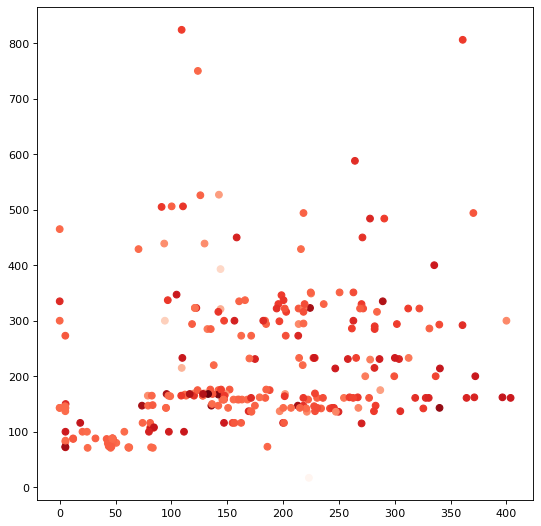

In [422]:
plt.figure(figsize = (8, 8), dpi = 80)

notes_df["speed"] = notes_df.apply(lambda row: row["in_dist"] / row["in_timedelta"], axis = 1)

plt.scatter("in_dist", "in_timedelta", c = "p_miss", cmap = "Reds", data = notes_df)

### Visualize Beatmap Difficulty

In [423]:
NUM_VISUAL_TESTS = 597

def load_visual_dataset(filenames):

    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = True 

    dataset = tf.data.TFRecordDataset(
        filenames,
        compression_type = "ZLIB"
    ) 

    dataset = dataset.map(
        parse_example, num_parallel_calls = 1
    )

    return dataset

def get_visual_dataset(filenames):

    dataset = load_visual_dataset(filenames)
    dataset = dataset.flat_map(reformat_example)
    dataset = dataset.batch(NOTES_PER_REPLAY * NUM_VISUAL_TESTS)

    return dataset

In [280]:
# model = build_naive_model()
# model.load_weights("naive0.h5")

In [426]:
visual_dataset = get_visual_dataset(VISUAL_FILENAMES)
visual_df = pd.read_csv("../data/indices/visual_index.csv")

In [427]:
visual_features, visual_labels = next(iter(visual_dataset))
visual_probs = model.predict_on_batch(visual_features)

visual_notes_df = pd.DataFrame(
    np.concatenate(
        (visual_features[:, :BEATMAP_CONTEXT_DIM], visual_features[:, -EMBEDDING_DIM:], visual_labels, visual_probs), 
        axis = 1
    ), columns = context_labels + emb_labels + true_labels + prob_labels
)

print(len(visual_notes_df))
visual_notes_df.head()

152832


,ar,od,cs,hd,x_pos,y_pos,in_x_offset,in_y_offset,in_dist,in_timedelta,...,slider_num_ticks,slider_num_beats,300,100,50,miss,p_300,p_100,p_50,p_miss
0,9.3,8.4,4.2,1.0,482.0,30.0,379.0,-354.0,518.610657,428.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.883424,0.083689,0.005555,0.027332
1,9.3,8.4,4.2,1.0,103.0,384.0,-7.0,41.0,41.593269,86.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.880697,0.086289,0.006002,0.027012
2,9.3,8.4,4.2,1.0,110.0,343.0,-7.0,41.0,41.593269,86.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.801238,0.150277,0.022903,0.025582
3,9.3,8.4,4.2,1.0,117.0,302.0,-7.0,41.0,41.593269,85.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.812169,0.142322,0.020040,0.025468
4,9.3,8.4,4.2,1.0,124.0,261.0,-30.0,87.0,92.027168,343.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.816754,0.138907,0.018875,0.025464


In [428]:
visual_notes_df["neg_log_p_300"] = visual_notes_df["p_300"].apply(lambda p: -np.log(p))

pps = []

for idx in range(NUM_VISUAL_TESTS):
    pps.append( np.sum(visual_notes_df["neg_log_p_300"].iloc[idx * NOTES_PER_REPLAY : (idx + 1) * NOTES_PER_REPLAY]) )
    
visual_df["neg_loglik_SS"] = pps
visual_df = visual_df.sort_values(by = "neg_loglik_SS", ascending = False).drop_duplicates()
visual_df.to_csv("naive1_pps.csv", index = False)

visual_df

,beatmap_name,mods,stars_live,neg_loglik_SS
270,Various Artist - Oriental's Long Stream Practi...,NM,4.568090,99.962202
208,Various Artist - Oriental's Long Stream Practi...,NM,6.309763,96.801481
330,e-ZUKA - Assailant in the Night [a],NM,8.256209,90.429375
501,Various Artist - Long Stream Practice Maps [Ai...,NF,3.294525,89.500522
450,REDALiCE - Great nano desu [Insane],NM,5.252776,88.568367
...,...,...,...,...
432,HAG - Colorful [Nevo's Expert],NM,5.473919,15.938779
309,Camellia - Exit This Earth's Atomosphere [Evol...,NM,6.748055,15.741425
98,Camellia feat. Nanahira - finorza [Collab Anot...,NM,4.807924,15.468591
340,Syoko Hoshi (CV: Satsumi Matsuda) - Zettai Tok...,HD,4.019960,14.831785


In [432]:
visual_df.sort_values(by = "neg_loglik_SS", ascending = False)[:32]

,beatmap_name,mods,stars_live,neg_loglik_SS
270,Various Artist - Oriental's Long Stream Practi...,NM,4.568090,99.962202
208,Various Artist - Oriental's Long Stream Practi...,NM,6.309763,96.801481
330,e-ZUKA - Assailant in the Night [a],NM,8.256209,90.429375
501,Various Artist - Long Stream Practice Maps [Ai...,NF,3.294525,89.500522
450,REDALiCE - Great nano desu [Insane],NM,5.252776,88.568367
53,Nekrogoblikon - The Skin Thief [Murder],NM,7.071175,83.193621
297,Ne Obliviscaris - Painters GAMMA [240 BPM],HD,6.571924,75.641391
77,Nanahoshi Kangengakudan - Rubik's Cube [Chaos'...,NM,5.464273,74.116354
375,Unknown Artist - LEGIA TO CHUJE [Ultimate 2021...,NM,6.695980,73.778053
179,isoganakya - isogu (Stream Practice Maps) [300...,NM,7.451979,73.600260


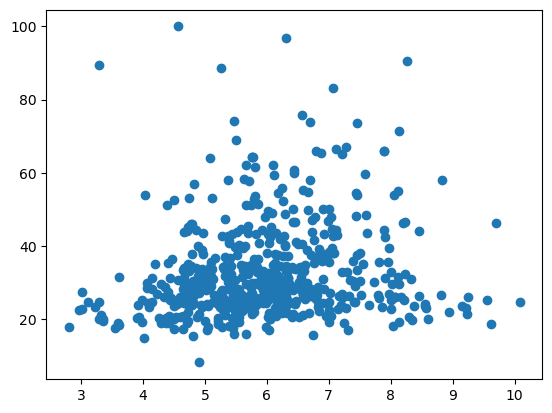

In [438]:
plt.scatter("stars_live", "neg_loglik_SS", data = visual_df)

In [433]:
def plot_replay_idx(replay_idx, visual_notes_df):
    plt.plot(range(1, NOTES_PER_REPLAY + 1), visual_notes_df.iloc[replay_idx * NOTES_PER_REPLAY : (replay_idx + 1) * NOTES_PER_REPLAY]["p_300"][::-1], color = "blue")
    plt.plot(range(1, NOTES_PER_REPLAY + 1), visual_notes_df.iloc[replay_idx * NOTES_PER_REPLAY : (replay_idx + 1) * NOTES_PER_REPLAY]["p_100"][::-1], color = "green")
    plt.plot(range(1, NOTES_PER_REPLAY + 1), visual_notes_df.iloc[replay_idx * NOTES_PER_REPLAY : (replay_idx + 1) * NOTES_PER_REPLAY]["p_50"][::-1], color = "purple")
    plt.plot(range(1, NOTES_PER_REPLAY + 1), visual_notes_df.iloc[replay_idx * NOTES_PER_REPLAY : (replay_idx + 1) * NOTES_PER_REPLAY]["p_miss"][::-1], color = "red")

### Some Examples

#### ZYTOKINE - Dancing Dollz feat. cold kiss - REDALiCE Remix [Extra] (HD)

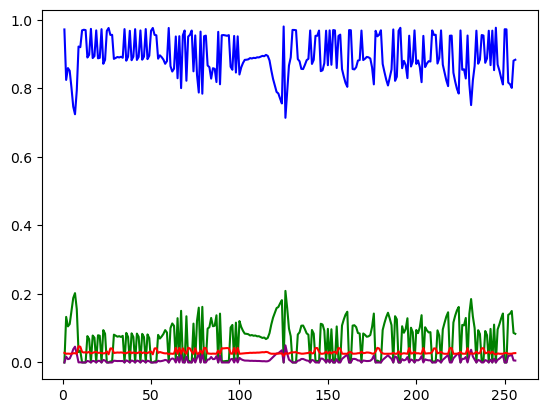

In [434]:
plot_replay_idx(0, visual_notes_df)

#### ayase rie - yuima-ru*world [Real's Insane] (HD)

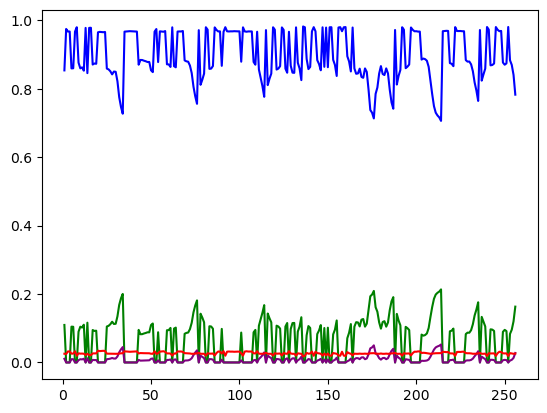

In [435]:
plot_replay_idx(1, visual_notes_df)

#### Sunless Rise - Awakening [Untruth] (NM)

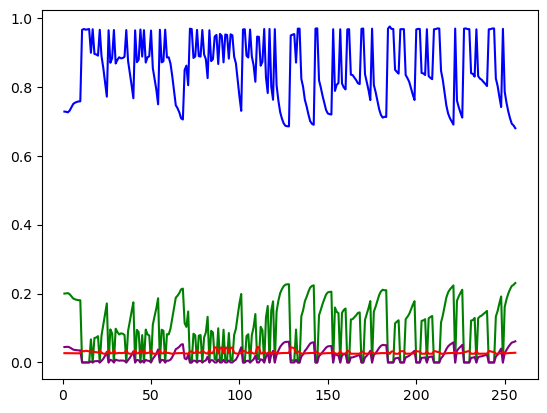

In [439]:
plot_replay_idx(2, visual_notes_df)

#### Ray - km/h (TV Size) [Gotta Go Fast!] (NM)

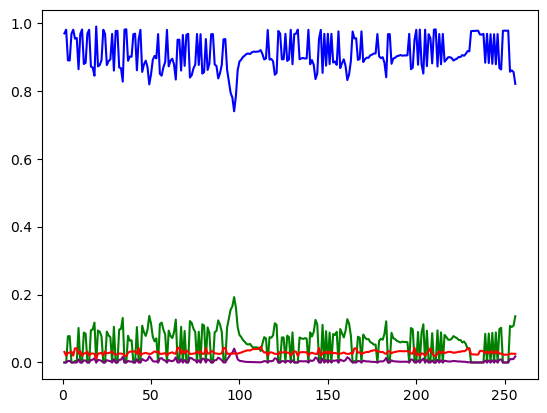

In [440]:
plot_replay_idx(3, visual_notes_df)